# Chess Board Position Recogniser

## Setup

### Libraries

In [1]:
import pathlib
import sys

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from PIL import Image

import chess


# Models
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet import ResNet152

from tensorflow.keras.applications.densenet import DenseNet121

from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications import MobileNetV3Large

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

import wandb

# Utils
sys.path.append('../utils')
from dataset_loader import populate_test_folder, load_dataset, load_train_valid_test_dataset
from visualisation import display_cropped_chess_board


In [2]:
tf.__version__

'2.10.0'

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Constants

In [4]:
DATASET_DIR = pathlib.Path.cwd().parent / "data"

PIECE_LABELS = ['_', 'p', 'n', 'b', 'r', 'q', 'k', 'P', 'N', 'B', 'R', 'Q', 'K']
NUM_CLASSES = len(PIECE_LABELS)

## Dataset

### Fetch Dataset From W&B

In [5]:
run = wandb.init(project="deepconvchess")

dataset_artifact = run.use_artifact('deepconvchess-dataset:latest')
dataset_artifact.download(root=str(DATASET_DIR))

populate_test_folder(DATASET_DIR)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: billy-wba8. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact deepconvchess-dataset:latest, 198.50MB. 1075 files... 
wandb:   1075 of 1075 files downloaded.  
Done. 0:0:0.2


### Load X and Y Dataset

Load images from real/ and render/ as train/validation split and test/ as test dataset

In [5]:
X_train, y_train, X_val, y_val, X_test, y_test = load_train_valid_test_dataset(DATASET_DIR)

Processing render/1N2r3_2q1ppkp_1p1p1np1_p1nP4_2P2P2_1P4P1_P2Q2BP_3RR1K1 b - - 0 21.jpeg
Processing render/1n6_8_1k6_1pp5_8_8_8_1K6 w - - 8 68.jpeg
Processing render/1n6_8_1k6_1pp5_8_8_8_2K5 b - - 9 68.jpeg
Processing render/1q2r3_4ppkp_1p1p1np1_p1nP4_2P2P2_1P4P1_P2Q2BP_3RR1K1 w - - 0 22.jpeg
Processing render/1q2r3_4ppkp_1p1p1np1_p1nP4_2PQ1P2_1P4P1_P5BP_3RR1K1 b - - 1 22.jpeg
Processing render/1r1q1k1r_4pp1p_2Bp2p1_2p1b3_1p3P2_3P2PP_PP2Q3_R4RK1 b - - 0 19.jpeg
Processing render/1r1q1k1r_4pp1p_2Bp2p1_2p1b3_1p6_3P2PP_PP2QP2_R4RK1 w - - 2 19.jpeg
Processing render/1r1q1k1r_4pp1p_2Bp2p1_2p5_1p1b1P2_3P2PP_PP2Q2K_R4R2 b - - 2 20.jpeg
Processing render/1r1q1k1r_4pp1p_2Bp2p1_2p5_1p1b1P2_3P2PP_PP2Q3_R4RK1 w - - 1 20.jpeg
Processing render/1r1q1k1r_5p1p_2Bpp1p1_2p5_1p1b1P2_3P2PP_PP2Q2K_4RR2 b - - 1 21.jpeg
Processing render/1r1q1k1r_5p1p_2Bpp1p1_2p5_1p1b1P2_3P2PP_PP2Q2K_R4R2 w - - 0 21.jpeg
Processing render/1r1q1k1r_5p2_2Bpp1p1_2p4p_1p1b1P2_1P1P2PP_P3Q2K_4RR2 b - - 0 22.jpeg
Processing render/

In [6]:
print("X_train shape: " + str(X_train.shape))
print("y_train shape: " + str(y_train.shape))
print("X_val shape: " + str(X_val.shape))
print("y_val shape: " + str(y_val.shape))
print("X_test shape: " + str(X_test.shape))
print("y_test shape: " + str(y_test.shape))

X_train shape: (54118, 160, 160, 3)
y_train shape: (54118,)
X_val shape: (13530, 160, 160, 3)
y_val shape: (13530,)
X_test shape: (1152, 160, 160, 3)
y_test shape: (1152,)


In [7]:
total_images = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]

print("Train Split: {:.2%}".format(X_train.shape[0] / total_images))
print("Validation Split: {:.2%}".format(X_val.shape[0] / total_images))
print("Test Split: {:.2%}".format(X_test.shape[0] / total_images))

Train Split: 78.66%
Validation Split: 19.67%
Test Split: 1.67%


### Display Example Cropped Board

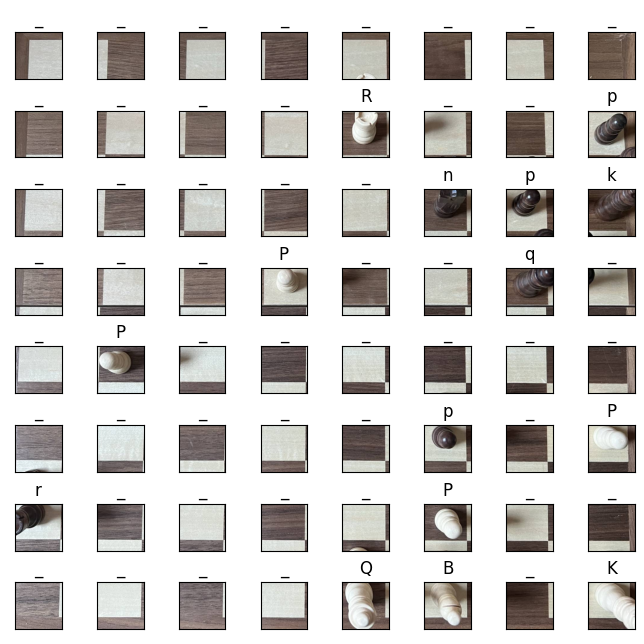

In [8]:
display_cropped_chess_board(X_test[0:64], y_test[0:64])

### Encode Labels

In [9]:
label_encoder = LabelEncoder()
label_encoder.fit(PIECE_LABELS)

y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

## Weights and Bias

### Callback to Log Statistics

In [10]:
class EpochLogCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_acc = logs.get('accuracy')
        train_loss = logs.get('loss')
        
        val_acc = logs.get('val_accuracy')
        val_loss = logs.get('val_loss')

        wandb.log(
            {
                'accuracy': train_acc, 
                'loss': train_loss,
                'val_accuracy': val_acc,
                'val_loss': val_loss
            }
        )

## Models

### ResNet

#### ResNet-50

In [11]:
# Start W&B Run
wandb.init(
    project="deepconvchess",
    config={
        "architecture": "renset50",
        "optimizer": "adam",
        "learning_rate": 0.0001,
        "loss": "sparse_categorical_crossentropy",
        "metric": "accuracy",
        "batch_size": 32,
        "epochs": 5,
        "train_size": len(X_train),
        "val_size": len(X_val),
        "test_size": len(X_test)
    }
)

config = wandb.config

# Create Model
resnet_model = ResNet50(input_shape=(160, 160, 3), include_top=False)
resnet_model.trainable = False

model = Sequential([
    resnet_model, 
    Flatten(), 
    Dense(NUM_CLASSES, activation='softmax', name='output') # Additional output layer for chess pieces
], name=config.architecture)

# Create Optimizer
if config.optimizer == 'adam':
    optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

# Compile Model
model.compile(optimizer=optimizer, loss=config.loss, metrics=[config.metric])

# Build Model
with tf.device('/GPU:0'):
    history = model.fit(X_train, 
                        y_train,
                        batch_size=config.batch_size,
                        epochs=config.epochs,
                        validation_data=(X_val, y_val),
                        callbacks=[EpochLogCallback()]) # Log statistics to W&B

# Finish W&B Run
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: billy-wba8. Use `wandb login --relogin` to force relogin


Epoch 1/5
1692/1692 [==============================] - 75s 41ms/step - loss: 0.0641 - accuracy: 0.9835 - val_loss: 0.0251 - val_accuracy: 0.9950
Epoch 2/5
1692/1692 [==============================] - 69s 41ms/step - loss: 0.0091 - accuracy: 0.9975 - val_loss: 0.0215 - val_accuracy: 0.9958
Epoch 3/5
1692/1692 [==============================] - 69s 41ms/step - loss: 0.0085 - accuracy: 0.9982 - val_loss: 0.0247 - val_accuracy: 0.9956
Epoch 4/5
1692/1692 [==============================] - 69s 41ms/step - loss: 0.0040 - accuracy: 0.9989 - val_loss: 0.0218 - val_accuracy: 0.9965
Epoch 5/5
1692/1692 [==============================] - 70s 41ms/step - loss: 0.0104 - accuracy: 0.9981 - val_loss: 0.0430 - val_accuracy: 0.9933


accuracy,▁▇███
loss,█▂▂▁▂
val_accuracy,▅▇▆█▁
val_loss,▂▁▂▁█
accuracy,0.9981
loss,0.01036
val_accuracy,0.99335
val_loss,0.04303


#### ResNet-152

In [24]:
# Start W&B Run
wandb.init(
    project="deepconvchess",
    config={
        "architecture": "renset152",
        "optimizer": "adam",
        "learning_rate": 0.0001,
        "loss": "sparse_categorical_crossentropy",
        "metric": "accuracy",
        "batch_size": 32,
        "epochs": 5,
        "train_size": len(X_train),
        "val_size": len(X_val),
        "test_size": len(X_test)
    }
)

config = wandb.config

# Create Model
resnet_model = ResNet152(input_shape=(160, 160, 3), include_top=False)
resnet_model.trainable = False

model = Sequential([
    resnet_model, 
    Flatten(), 
    Dense(NUM_CLASSES, activation='softmax', name='output') # Additional output layer for chess pieces
], name=config.architecture)

# Create Optimizer
if config.optimizer == 'adam':
    optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

# Compile Model
model.compile(optimizer=optimizer, loss=config.loss, metrics=[config.metric])

# Build Model
with tf.device('/GPU:0'):
    history = model.fit(X_train, 
                        y_train,
                        batch_size=config.batch_size,
                        epochs=config.epochs,
                        validation_data=(X_val, y_val),
                        callbacks=[EpochLogCallback()]) # Log statistics to W&B

# Finish W&B Run
wandb.finish()

Epoch 1/5
1668/1668 [==============================] - 148s 85ms/step - loss: 0.0749 - accuracy: 0.9815 - val_loss: 0.0296 - val_accuracy: 0.9926
Epoch 2/5
1668/1668 [==============================] - 140s 84ms/step - loss: 0.0142 - accuracy: 0.9963 - val_loss: 0.0490 - val_accuracy: 0.9906
Epoch 3/5
1668/1668 [==============================] - 143s 86ms/step - loss: 0.0113 - accuracy: 0.9976 - val_loss: 0.0190 - val_accuracy: 0.9956
Epoch 4/5
1668/1668 [==============================] - 138s 83ms/step - loss: 0.0090 - accuracy: 0.9982 - val_loss: 0.0126 - val_accuracy: 0.9978
Epoch 5/5
1668/1668 [==============================] - 140s 84ms/step - loss: 0.0075 - accuracy: 0.9985 - val_loss: 0.0312 - val_accuracy: 0.9951


accuracy,▁▇███
loss,█▂▁▁▁
val_accuracy,▃▁▆█▅
val_loss,▄█▂▁▅
accuracy,0.99846
loss,0.00751
val_accuracy,0.99505
val_loss,0.03121


### DenseNet

#### DenseNet-121

In [28]:
# Start W&B Run
wandb.init(
    project="deepconvchess",
    config={
        "architecture": "densenet121",
        "optimizer": "adam",
        "learning_rate": 0.0001,
        "loss": "sparse_categorical_crossentropy",
        "metric": "accuracy",
        "batch_size": 32,
        "epochs": 5,
        "train_size": len(X_train),
        "val_size": len(X_val),
        "test_size": len(X_test)
    }
)

config = wandb.config

# Create Model
densenet_model = DenseNet121(input_shape=(160, 160, 3), include_top=False)
densenet_model.trainable = False

model = Sequential([
    resnet_model, 
    Flatten(), 
    Dense(NUM_CLASSES, activation='softmax', name='output') # Additional output layer for chess pieces
], name=config.architecture)

# Create Optimizer
if config.optimizer == 'adam':
    optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

# Compile Model
model.compile(optimizer=optimizer, loss=config.loss, metrics=[config.metric])

# Build Model
with tf.device('/GPU:0'):
    history = model.fit(X_train, 
                        y_train,
                        batch_size=config.batch_size,
                        epochs=config.epochs,
                        validation_data=(X_val, y_val),
                        callbacks=[EpochLogCallback()]) # Log statistics to W&B

# Finish W&B Run
wandb.finish()

Epoch 1/5
1668/1668 [==============================] - 86s 49ms/step - loss: 0.4564 - accuracy: 0.9099 - val_loss: 0.2534 - val_accuracy: 0.9475
Epoch 2/5
1668/1668 [==============================] - 78s 47ms/step - loss: 0.2077 - accuracy: 0.9564 - val_loss: 0.1584 - val_accuracy: 0.9685
Epoch 3/5
1668/1668 [==============================] - 80s 48ms/step - loss: 0.1604 - accuracy: 0.9674 - val_loss: 0.2852 - val_accuracy: 0.9594
Epoch 4/5
1668/1668 [==============================] - 80s 48ms/step - loss: 0.1578 - accuracy: 0.9701 - val_loss: 1.2088 - val_accuracy: 0.8965
Epoch 5/5
1668/1668 [==============================] - 81s 49ms/step - loss: 0.1383 - accuracy: 0.9764 - val_loss: 0.1605 - val_accuracy: 0.9729


accuracy,▁▆▇▇█
loss,█▃▁▁▁
val_accuracy,▆█▇▁█
val_loss,▂▁▂█▁
accuracy,0.97636
loss,0.13828
val_accuracy,0.97286
val_loss,0.16052


### MobileNet

#### MobileNetV1

In [13]:
# Start W&B Run
wandb.init(
    project="deepconvchess",
    config={
        "architecture": "mobilenetv1",
        "optimizer": "adam",
        "learning_rate": 0.0001,
        "loss": "sparse_categorical_crossentropy",
        "metric": "accuracy",
        "batch_size": 32,
        "epochs": 5,
        "train_size": len(X_train),
        "val_size": len(X_val),
        "test_size": len(X_test)
    }
)

config = wandb.config

# Create Model
mobilenet_model = MobileNet(input_shape=(160, 160, 3), include_top=False)
mobilenet_model.trainable = False

model = Sequential([
    mobilenet_model, 
    Flatten(), 
    Dense(NUM_CLASSES, activation='softmax', name='output') # Additional output layer for chess pieces
], name=config.architecture)

# Create Optimizer
if config.optimizer == 'adam':
    optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

# Compile Model
model.compile(optimizer=optimizer, loss=config.loss, metrics=[config.metric])

# Build Model
with tf.device('/GPU:0'):
    history = model.fit(X_train, 
                        y_train,
                        batch_size=config.batch_size,
                        epochs=config.epochs,
                        validation_data=(X_val, y_val),
                        callbacks=[EpochLogCallback()])

# Finish W&B Run
wandb.finish()

Epoch 1/5
1668/1668 [==============================] - 29s 15ms/step - loss: 0.2873 - accuracy: 0.9163 - val_loss: 0.1744 - val_accuracy: 0.9472
Epoch 2/5
1668/1668 [==============================] - 24s 14ms/step - loss: 0.1157 - accuracy: 0.9648 - val_loss: 0.1138 - val_accuracy: 0.9672
Epoch 3/5
1668/1668 [==============================] - 25s 15ms/step - loss: 0.0768 - accuracy: 0.9774 - val_loss: 0.1296 - val_accuracy: 0.9594
Epoch 4/5
1668/1668 [==============================] - 25s 15ms/step - loss: 0.0561 - accuracy: 0.9839 - val_loss: 0.0859 - val_accuracy: 0.9732
Epoch 5/5
1668/1668 [==============================] - 24s 15ms/step - loss: 0.0427 - accuracy: 0.9880 - val_loss: 0.0986 - val_accuracy: 0.9700


accuracy,▁▆▇██
loss,█▃▂▁▁
val_accuracy,▁▆▄█▇
val_loss,█▃▄▁▂
accuracy,0.98804
loss,0.04269
val_accuracy,0.97001
val_loss,0.09859


#### MobileNetV2

In [22]:
# Start W&B Run
wandb.init(
    project="deepconvchess",
    config={
        "architecture": "mobilenetv2",
        "optimizer": "adam",
        "learning_rate": 0.0001,
        "loss": "sparse_categorical_crossentropy",
        "metric": "accuracy",
        "batch_size": 32,
        "epochs": 5,
        "train_size": len(X_train),
        "val_size": len(X_val),
        "test_size": len(X_test)
    }
)

config = wandb.config

# Create Model
mobilenet_model = MobileNetV2(input_shape=(160, 160, 3), include_top=False)
mobilenet_model.trainable = False

model = Sequential([
    mobilenet_model, 
    Flatten(), 
    Dense(NUM_CLASSES, activation='softmax', name='output') # Additional output layer for chess pieces
], name=config.architecture)

# Create Optimizer
if config.optimizer == 'adam':
    optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

# Compile Model
model.compile(optimizer=optimizer, loss=config.loss, metrics=[config.metric])

# Build Model
with tf.device('/GPU:0'):
    history = model.fit(X_train, 
                        y_train,
                        batch_size=config.batch_size,
                        epochs=config.epochs,
                        validation_data=(X_val, y_val),
                        callbacks=[EpochLogCallback()])

# Finish W&B Run
wandb.finish()

Epoch 1/5
756/756 [==============================] - 16s 19ms/step - loss: 0.1180 - accuracy: 0.9718 - val_loss: 0.0334 - val_accuracy: 0.9930
Epoch 2/5
756/756 [==============================] - 14s 18ms/step - loss: 0.0151 - accuracy: 0.9971 - val_loss: 0.0238 - val_accuracy: 0.9949
Epoch 3/5
756/756 [==============================] - 16s 21ms/step - loss: 0.0065 - accuracy: 0.9989 - val_loss: 0.0194 - val_accuracy: 0.9962
Epoch 4/5
756/756 [==============================] - 15s 20ms/step - loss: 0.0027 - accuracy: 0.9998 - val_loss: 0.0194 - val_accuracy: 0.9962
Epoch 5/5
756/756 [==============================] - 14s 19ms/step - loss: 0.0015 - accuracy: 0.9999 - val_loss: 0.0133 - val_accuracy: 0.9967


accuracy,▁▇███
loss,█▂▁▁▁
val_accuracy,▁▄▇▇█
val_loss,█▅▃▃▁
accuracy,0.99992
loss,0.00153
val_accuracy,0.99669
val_loss,0.01326


#### MobileNetV3

##### MobileNetV3-Small

In [14]:
# Start W&B Run
wandb.init(
    project="deepconvchess",
    config={
        "architecture": "mobilenetv3-small",
        "optimizer": "adam",
        "learning_rate": 0.0001,
        "loss": "sparse_categorical_crossentropy",
        "metric": "accuracy",
        "batch_size": 32,
        "epochs": 5,
        "train_size": len(X_train),
        "val_size": len(X_val),
        "test_size": len(X_test)
    }
)

config = wandb.config

# Create Model
mobilenet_model = MobileNetV3Small(input_shape=(160, 160, 3), include_top=False)
mobilenet_model.trainable = False

model = Sequential([
    mobilenet_model, 
    Flatten(), 
    Dense(NUM_CLASSES, activation='softmax', name='output') # Additional output layer for chess pieces
], name=config.architecture)

# Create Optimizer
if config.optimizer == 'adam':
    optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

# Compile Model
model.compile(optimizer=optimizer, loss=config.loss, metrics=[config.metric])

# Build Model
with tf.device('/GPU:0'):
    history = model.fit(X_train, 
                        y_train,
                        batch_size=config.batch_size,
                        epochs=config.epochs,
                        validation_data=(X_val, y_val),
                        callbacks=[EpochLogCallback()])

# Finish W&B Run
wandb.finish()

Epoch 1/5
1668/1668 [==============================] - 30s 17ms/step - loss: 0.0859 - accuracy: 0.9765 - val_loss: 0.0123 - val_accuracy: 0.9966
Epoch 2/5
1668/1668 [==============================] - 28s 17ms/step - loss: 0.0038 - accuracy: 0.9993 - val_loss: 0.0071 - val_accuracy: 0.9981
Epoch 3/5
1668/1668 [==============================] - 27s 16ms/step - loss: 9.6524e-04 - accuracy: 1.0000 - val_loss: 0.0049 - val_accuracy: 0.9987
Epoch 4/5
1668/1668 [==============================] - 27s 16ms/step - loss: 3.8638e-04 - accuracy: 1.0000 - val_loss: 0.0040 - val_accuracy: 0.9988
Epoch 5/5
1668/1668 [==============================] - 26s 16ms/step - loss: 1.7343e-04 - accuracy: 1.0000 - val_loss: 0.0040 - val_accuracy: 0.9989


accuracy,▁████
loss,█▁▁▁▁
val_accuracy,▁▅▇██
val_loss,█▄▂▁▁
accuracy,1.0
loss,0.00017
val_accuracy,0.99888
val_loss,0.00397


##### MobileNetV3-Large

In [19]:
# Start W&B Run
wandb.init(
    project="deepconvchess",
    config={
        "architecture": "mobilenetv3-large",
        "optimizer": "adam",
        "learning_rate": 0.0001,
        "loss": "sparse_categorical_crossentropy",
        "metric": "accuracy",
        "batch_size": 32,
        "epochs": 5,
        "train_size": len(X_train),
        "val_size": len(X_val),
        "test_size": len(X_test)
    }
)

config = wandb.config

# Create Model
mobilenet_model = MobileNetV3Large(input_shape=(160, 160, 3), include_top=False)
mobilenet_model.trainable = False

model = Sequential([
    mobilenet_model, 
    Flatten(), 
    Dense(NUM_CLASSES, activation='softmax', name='output') # Additional output layer for chess pieces
], name=config.architecture)

# Create Optimizer
if config.optimizer == 'adam':
    optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

# Compile Model
model.compile(optimizer=optimizer, loss=config.loss, metrics=[config.metric])

# Build Model
with tf.device('/GPU:0'):
    history = model.fit(X_train, 
                        y_train,
                        batch_size=config.batch_size,
                        epochs=config.epochs,
                        validation_data=(X_val, y_val),
                        callbacks=[EpochLogCallback()])

# Finish W&B Run
wandb.finish()

Epoch 1/5
1668/1668 [==============================] - 39s 22ms/step - loss: 0.0627 - accuracy: 0.9828 - val_loss: 0.0071 - val_accuracy: 0.9980
Epoch 2/5
1668/1668 [==============================] - 36s 22ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.0047 - val_accuracy: 0.9989
Epoch 3/5
1668/1668 [==============================] - 34s 20ms/step - loss: 7.9829e-04 - accuracy: 0.9999 - val_loss: 0.0037 - val_accuracy: 0.9990
Epoch 4/5
1668/1668 [==============================] - 34s 21ms/step - loss: 1.0835e-04 - accuracy: 1.0000 - val_loss: 0.0037 - val_accuracy: 0.9990
Epoch 5/5
1668/1668 [==============================] - 35s 21ms/step - loss: 4.6535e-05 - accuracy: 1.0000 - val_loss: 0.0033 - val_accuracy: 0.9991


accuracy,▁████
loss,█▁▁▁▁
val_accuracy,▁▇▇██
val_loss,█▄▂▂▁
accuracy,1.0
loss,5e-05
val_accuracy,0.9991
val_loss,0.00328


### Evaluate Model

#### Predictions

In [ ]:
for i in range(0, 8):
    image = np.expand_dims(X_val[i], axis=0)

    prediction = model.predict(image)
    prediction = label_encoder.inverse_transform(np.argmax(prediction, axis=1))

    print("True Label: %s, Predicted Label: %s\n" % (label_encoder.inverse_transform([y_val[i]]), prediction))

1/1 [==============================] - 1s 704ms/step
True Label: ['_'], Predicted Label: ['_']

1/1 [==============================] - 0s 23ms/step
True Label: ['n'], Predicted Label: ['n']

1/1 [==============================] - 0s 20ms/step
True Label: ['P'], Predicted Label: ['P']

1/1 [==============================] - 0s 20ms/step
True Label: ['_'], Predicted Label: ['_']

1/1 [==============================] - 0s 20ms/step
True Label: ['p'], Predicted Label: ['p']

1/1 [==============================] - 0s 19ms/step
True Label: ['q'], Predicted Label: ['q']

1/1 [==============================] - 0s 20ms/step
True Label: ['_'], Predicted Label: ['_']

1/1 [==============================] - 0s 21ms/step
True Label: ['N'], Predicted Label: ['N']



## Evaluation

### Validation Set

In [18]:
loss, accuracy = model.evaluate(X_val, y_val)

print('Val loss:', loss)
print('Val accuracy:', accuracy)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

### Test Set

In [30]:
len(X_test)

1152

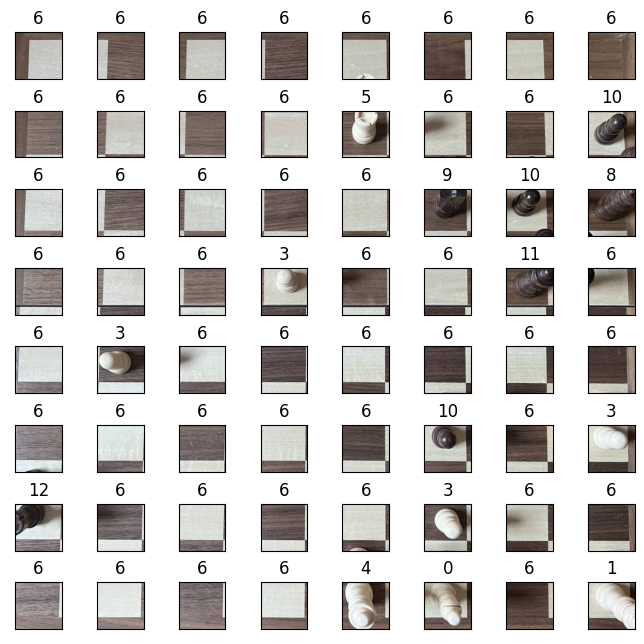

In [20]:
display_cropped_chess_board(X_test[0:64], y_test[0:64])

In [12]:
loss, accuracy = model.evaluate(X_test, y_test)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

36/36 [==============================] - 1s 34ms/step - loss: 0.1039 - accuracy: 0.9861
Test loss: 0.10390737652778625
Test accuracy: 0.9861111044883728


In [13]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

36/36 [==============================] - 2s 39ms/step


In [14]:
cf_y_test = 
cf_y_pred = 
cf_y_test

array(['_', '_', '_', ..., 'B', '_', 'R'], dtype='<U1')

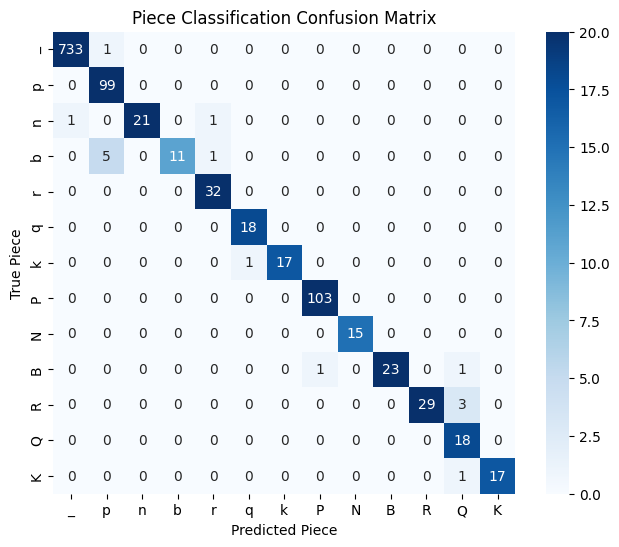

In [40]:
conf_matrix = confusion_matrix(
    y_true=label_encoder.inverse_transform(y_test), 
    y_pred=label_encoder.inverse_transform(y_pred), 
    labels=PIECE_LABELS
)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', square=True, xticklabels=PIECE_LABELS, yticklabels=PIECE_LABELS, vmax=20)
plt.xlabel('Predicted Piece')
plt.ylabel('True Piece')
plt.title('Piece Classification Confusion Matrix')
plt.show()

In [24]:
fen = "r5k1_3n1r1p_2RQ2p1_3P2q1_1P6_5p1P_5P2_2R2B1K b - - 1 29.jpg".split(".")[0]
fen = fen.replace("_", "/")
board = chess.Board(fen)

img = Image.open(DATASET_DIR / "test" / "r5k1_3n1r1p_2RQ2p1_3P2q1_1P6_5p1P_5P2_2R2B1K b - - 1 29.jpg")
IMG_WIDTH, IMG_HEIGHT = img.size

X_unseen = []

# Crop each image into 64 sections, one for each tile on the board
for i in range(8):
    for j in range(8):
        crop_x = j * IMG_WIDTH // 8
        crop_y = i * IMG_HEIGHT // 8
        img_crop = img.crop((crop_x, crop_y, crop_x + IMG_WIDTH // 8, crop_y + IMG_HEIGHT // 8))

        piece = board.piece_at(((7 - i) * 8) + j)
        if piece is not None:
            piece = piece.symbol()
        else:
            piece = '_'

        X_unseen.append(np.array(img_crop))

In [25]:
len(X_unseen)

64

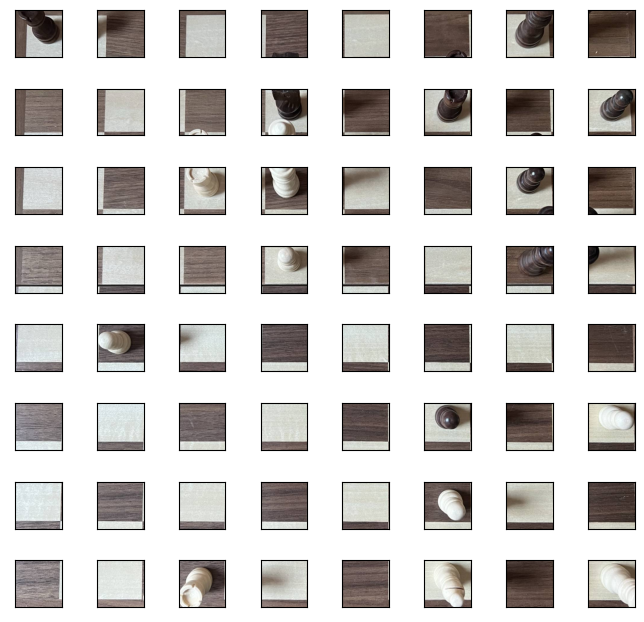

In [26]:
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(wspace=0.75)

for i in range(0, 64):
    fig.add_subplot(8, 8, i + 1)
    plt.imshow(X_unseen[i])
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])

In [27]:
y_pred = []
for i in range(0, 64):
    image = np.expand_dims(X_unseen[i], axis=0)

    prediction = model.predict(image)
    prediction = label_encoder.inverse_transform(np.argmax(prediction, axis=1))

    y_pred.append(prediction[0])

1/1 [==============================] - 0s 20ms/step


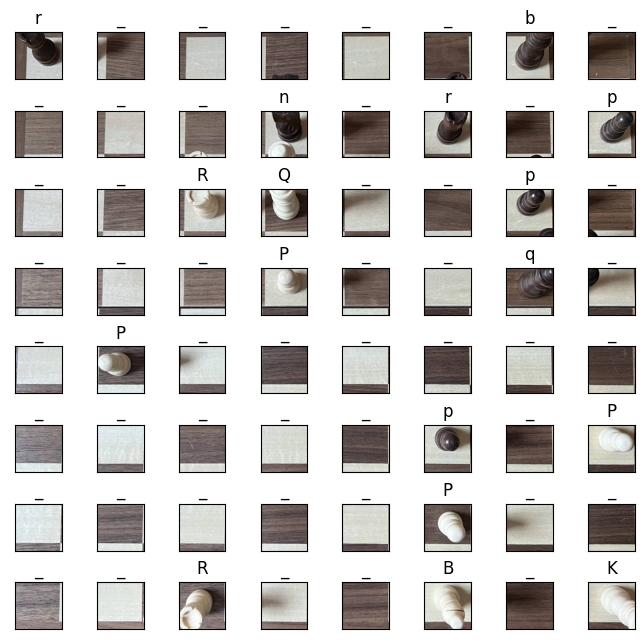

In [28]:
display_cropped_chess_board(X_unseen, y_pred)

In [ ]:
for i in range(0, len(predicted_y)):
    if predicted_y[i] != '_':
        piece = chess.Piece.from_symbol(predicted_y[i])
        square = chess.SQUARES[63 - i]
        board.set_piece_at(square, piece)

predicted_fen = board.fen()
predicted_fen

'rkrqqrkr/pbpnrpbp/pp1pp1pq/3bR3/2RBPR2/Bp1pQ1kP/PKp2PBk/1KK2RK1 b - - 0 18'

NameError: name 'predicted_fen' is not defined

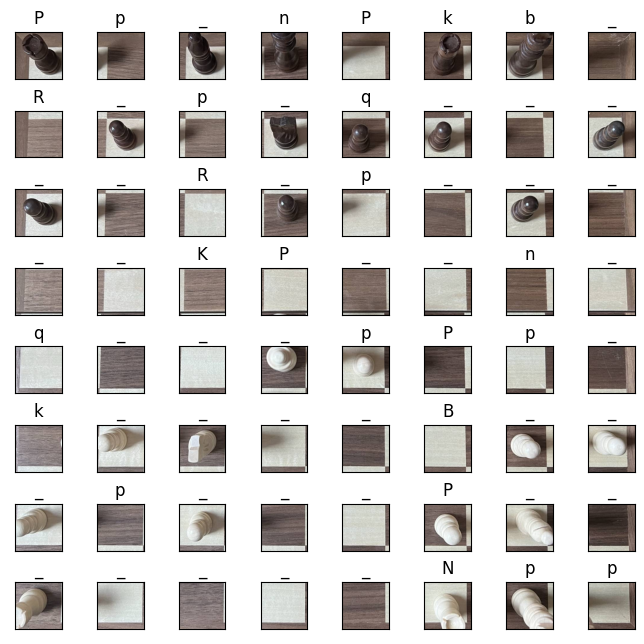

In [34]:
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(wspace=0.75)

for i in range(0, 64):
    fig.add_subplot(8, 8, i + 1)
    plt.imshow(X_test[i])
    plt.title(predicted_y[i])
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])

fig.suptitle("True FEN: rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR\nPredicted FEN: %s" % predicted_fen.split(" ")[0])
fig.savefig('predicted_board', dpi=300, bbox_inches='tight')